<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#特征工程" data-toc-modified-id="特征工程-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>特征工程</a></span><ul class="toc-item"><li><span><a href="#离群点检测" data-toc-modified-id="离群点检测-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>离群点检测</a></span></li><li><span><a href="#缺失值处理" data-toc-modified-id="缺失值处理-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>缺失值处理</a></span></li><li><span><a href="#数值2字符" data-toc-modified-id="数值2字符-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>数值2字符</a></span></li><li><span><a href="#创建新特征" data-toc-modified-id="创建新特征-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>创建新特征</a></span></li><li><span><a href="#数据标准化" data-toc-modified-id="数据标准化-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>数据标准化</a></span></li><li><span><a href="#空缺值填补" data-toc-modified-id="空缺值填补-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>空缺值填补</a></span></li><li><span><a href="#one-hot编码" data-toc-modified-id="one-hot编码-1.7"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>one-hot编码</a></span></li><li><span><a href="#合并所有特征" data-toc-modified-id="合并所有特征-1.8"><span class="toc-item-num">1.8&nbsp;&nbsp;</span>合并所有特征</a></span></li></ul></li></ul></div>

# 特征工程

导入工具包

In [1]:
# 数据读取及基本处理
import pandas as pd
import numpy as np

#查看数据分布是否对称/计算斜度/是否需要log或
from scipy.stats import skew

#可视化
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
# Definitions
pd.set_option('display.float_format', lambda x: '%.3f' % x) #float显示三位小数 
%matplotlib inline

In [2]:
# 设置一些全局的资源参数，可以进行个性化修改
import matplotlib
# 设置图片尺寸 14" x 7"
# rc: resource configuration
matplotlib.rc('figure', figsize = (12, 7))
# 设置字体 14
matplotlib.rc('font', size = 14)
# 不显示网格
matplotlib.rc('axes', grid = False)
# 设置背景颜色是白色
matplotlib.rc('axes', facecolor = 'white')

In [3]:
# 读入数据
dpath = './data/'
train = pd.read_csv(dpath + "train.csv")
test = pd.read_csv(dpath + "test.csv")

In [4]:
train.drop(['Id'], inplace = True, axis = 1)  #训练集Id不用，直接舍弃

test_id = test['Id']    #测试集Id暂时不用，存起来，提交时再用
test.drop(['Id'], inplace = True, axis = 1)

## 离群点检测

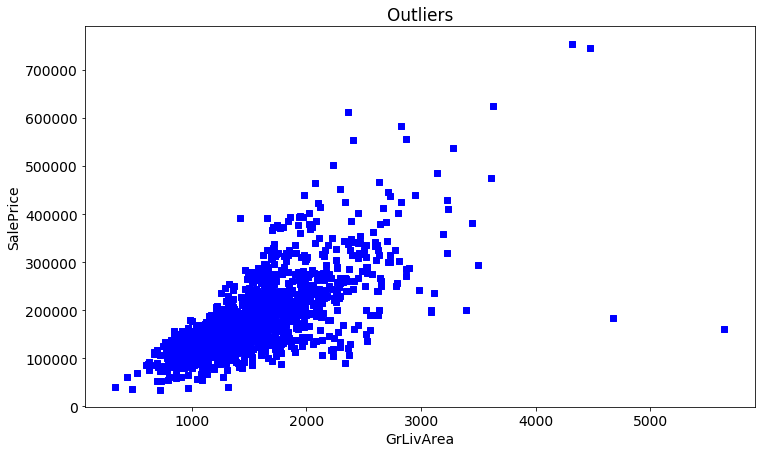

In [5]:
# 离群点检测（outliers），
plt.scatter(train.GrLivArea, train.SalePrice, c = "blue", marker = "s")
plt.title("Outliers")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()

#剔除离群点, 数据提供方寻底删除GrLivArea < 4000
train = train[train.GrLivArea < 4000]
temp = train.reindex()

散点图是一种直观发现outliers的方式。从上图中可以看出有2个极端的离群点在图的右下角（面积很大，但价格很低）。该数据集的提供者建议移除面积大于4000 square feet的数据点。
Reference : https://ww2.amstat.org/publications/jse/v19n3/decock.pdf

删除了4个样本点

In [6]:
train.shape

(1456, 80)

## 缺失值处理

In [7]:
train.isnull().sum().sort_values(ascending=False)[:10]

PoolQC          1451
MiscFeature     1402
Alley           1365
Fence           1176
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageCond        81
GarageFinish      81
GarageQual        81
dtype: int64

In [8]:
# Electrical只有一个nan,删除此行
train.dropna(axis=0, subset=["Electrical"], inplace=True)
# axis 指 轴，0是行，1是列，
# how 是删除条件：any 任意一个为na则删除整行/列,all 整行/列为na才删除
# inplace 是否在原DataFrame 上进行删除，false为否
train.shape

(1455, 80)

In [9]:
# 有些特征，用median/mean or most common value 填充没有意义
# 因为特征工程对训练集和测试都需要进行，
# 因此我们定义成函数，将数据集以参数形式传递
def process_missvalue_by_meaning (df):
    # Alley : data description says NA means "no alley access"
    df.loc[:, "Alley"] = df.loc[:, "Alley"].fillna("None")

    # BedroomAbvGr : NA most likely means 0
    df.loc[:, "BedroomAbvGr"] = df.loc[:, "BedroomAbvGr"].fillna(0)

    # BsmtQual etc : data description says NA for basement features is "no basement"
    df.loc[:, "BsmtQual"] = df.loc[:, "BsmtQual"].fillna("No")
    df.loc[:, "BsmtCond"] = df.loc[:, "BsmtCond"].fillna("No")
    df.loc[:, "BsmtExposure"] = df.loc[:, "BsmtExposure"].fillna("No")
    df.loc[:, "BsmtFinType1"] = df.loc[:, "BsmtFinType1"].fillna("No")
    df.loc[:, "BsmtFinType2"] = df.loc[:, "BsmtFinType2"].fillna("No")
    df.loc[:, "BsmtFullBath"] = df.loc[:, "BsmtFullBath"].fillna(0)
    df.loc[:, "BsmtHalfBath"] = df.loc[:, "BsmtHalfBath"].fillna(0)
    df.loc[:, "BsmtUnfSF"] = df.loc[:, "BsmtUnfSF"].fillna(0)

    # CentralAir : NA most likely means No
    df.loc[:, "CentralAir"] = df.loc[:, "CentralAir"].fillna("N")

    # Condition : NA most likely means Normal，靠近主干道或铁路
    df.loc[:, "Condition1"] = df.loc[:, "Condition1"].fillna("Norm")
    df.loc[:, "Condition2"] = df.loc[:, "Condition2"].fillna("Norm")

    # EnclosedPorch : NA most likely means no enclosed porch
    df.loc[:, "EnclosedPorch"] = df.loc[:, "EnclosedPorch"].fillna(0)

    # External stuff : NA most likely means average
    df.loc[:, "ExterCond"] = df.loc[:, "ExterCond"].fillna("TA")
    df.loc[:, "ExterQual"] = df.loc[:, "ExterQual"].fillna("TA")

    # Fence : data description says NA means "no fence"
    df.loc[:, "Fence"] = df.loc[:, "Fence"].fillna("No")

    # FireplaceQu : data description says NA means "no fireplace"
    df.loc[:, "FireplaceQu"] = df.loc[:, "FireplaceQu"].fillna("No")
    df.loc[:, "Fireplaces"] = df.loc[:, "Fireplaces"].fillna(0)

    # Functional : data description says NA means typical，家用（Home）功能性评级
    df.loc[:, "Functional"] = df.loc[:, "Functional"].fillna("Typ")

    # GarageType etc : data description says NA for garage features is "no garage"
    df.loc[:, "GarageType"] = df.loc[:, "GarageType"].fillna("No")
    df.loc[:, "GarageFinish"] = df.loc[:, "GarageFinish"].fillna("No")
    df.loc[:, "GarageQual"] = df.loc[:, "GarageQual"].fillna("No")
    df.loc[:, "GarageCond"] = df.loc[:, "GarageCond"].fillna("No")
    df.loc[:, "GarageArea"] = df.loc[:, "GarageArea"].fillna(0)
    df.loc[:, "GarageCars"] = df.loc[:, "GarageCars"].fillna(0)

    # HalfBath : NA most likely means no half baths above grade
    df.loc[:, "HalfBath"] = df.loc[:, "HalfBath"].fillna(0)

    # HeatingQC : NA most likely means typical
    df.loc[:, "HeatingQC"] = df.loc[:, "HeatingQC"].fillna("TA")

    # KitchenAbvGr : NA most likely means 0
    df.loc[:, "KitchenAbvGr"] = df.loc[:, "KitchenAbvGr"].fillna(0)

    # KitchenQual : NA most likely means typical
    df.loc[:, "KitchenQual"] = df.loc[:, "KitchenQual"].fillna("TA")

    # LotFrontage : NA most likely means no lot frontage
    df.loc[:, "LotFrontage"] = df.loc[:, "LotFrontage"].fillna(0)

    # LotShape : NA most likely means regular
    df.loc[:, "LotShape"] = df.loc[:, "LotShape"].fillna("Reg")

    # MasVnrType : NA most likely means no veneer，表层砌体（Masonry veneer）类型
    df.loc[:, "MasVnrType"] = df.loc[:, "MasVnrType"].fillna("None")
    df.loc[:, "MasVnrArea"] = df.loc[:, "MasVnrArea"].fillna(0)

    # MiscFeature : data description says NA means "no misc feature"
    df.loc[:, "MiscFeature"] = df.loc[:, "MiscFeature"].fillna("No")
    df.loc[:, "MiscVal"] = df.loc[:, "MiscVal"].fillna(0)

    # OpenPorchSF : NA most likely means no open porch
    df.loc[:, "OpenPorchSF"] = df.loc[:, "OpenPorchSF"].fillna(0)

    # PavedDrive : NA most likely means not paved
    df.loc[:, "PavedDrive"] = df.loc[:, "PavedDrive"].fillna("N")

    # PoolQC : data description says NA means "no pool"
    df.loc[:, "PoolQC"] = df.loc[:, "PoolQC"].fillna("No")
    df.loc[:, "PoolArea"] = df.loc[:, "PoolArea"].fillna(0)

    # SaleCondition : NA most likely means normal sale
    df.loc[:, "SaleCondition"] = df.loc[:, "SaleCondition"].fillna("Normal")

    # ScreenPorch : NA most likely means no screen porch，观景门廊
    df.loc[:, "ScreenPorch"] = df.loc[:, "ScreenPorch"].fillna(0)

    # TotRmsAbvGrd : NA most likely means 0
    df.loc[:, "TotRmsAbvGrd"] = df.loc[:, "TotRmsAbvGrd"].fillna(0)

    # Utilities : NA most likely means all public utilities
    df.loc[:, "Utilities"] = df.loc[:, "Utilities"].fillna("AllPub")

    # WoodDeckSF : NA most likely means no wood deck
    df.loc[:, "WoodDeckSF"] = df.loc[:, "WoodDeckSF"].fillna(0)
    
    return df
    
train = process_missvalue_by_meaning(train)
test = process_missvalue_by_meaning(test)

In [12]:
train.shape, test.shape

((1455, 80), (1459, 79))

## 数值2字符

In [13]:
#将数值型转换为字符型，原因是数值大小无明显意义，如仅表示类别
# Some numerical features are actually really categories
# MSSubClass：建筑类
#MoSold：销售月份

def numberical2cat(df):
    df.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                                       50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                                       80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                                       150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
                       "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
                                   7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
                      }, inplace = True)

    return df
train = numberical2cat(train)
test = numberical2cat(test)

In [14]:
#将字符型转换为数值型，原因是不同类别表示程度不同，可用数值大小表示程度深浅
# Encode some categorical features as ordered numbers when there is information in the order

In [15]:
# 字符 2 数值
def cat2numberical(df):
    df.replace({"Alley" : {"None": 0, "Grvl" : 1, "Pave" : 2},
                "BsmtCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                "BsmtExposure" : {"No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                "BsmtFinType1" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                "BsmtFinType2" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                "BsmtQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                "FireplaceQu" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
                                       "Min2" : 6, "Min1" : 7, "Typ" : 8},
                "GarageCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                "GarageQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                "PoolQC" : {"No" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                "Street" : {"Grvl" : 1, "Pave" : 2},
                "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}},
                       inplace = True
                     )
    return df

train = cat2numberical(train)
test = cat2numberical(test)

## 创建新特征

 1. 简化已有特征（将过于细致的分类转换为较粗略的分类）
 2. 联合已有特征（+ - * / ....）
 3. 现有重要特征（top 10）的多项式，并对原有数值特征进行数值变换（**2, **3, 根号2， 根号3， ....）

In [16]:
# Create new features
# 1* Simplifications of existing features
# 合并类别
def simplify(df):
    df["SimplOverallQual"] = df.OverallQual.replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                    4 : 2, 5 : 2, 6 : 2, # average
                                                    7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                    }, inplace = True)
    df["SimplOverallCond"] = df.OverallCond.replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                    4 : 2, 5 : 2, 6 : 2, # average
                                                    7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                    },inplace = True)
    df["SimplPoolQC"] = df.PoolQC.replace({1 : 1, 2 : 1, # average
                                           3 : 2, 4 : 2 # good
                                          },inplace = True)
    df["SimplGarageCond"] = df.GarageCond.replace({1 : 1, # bad
                                                2 : 1, 3 : 1, # average
                                                4 : 2, 5 : 2 # good
                                                        },inplace = True)
    df["SimplGarageQual"] = df.GarageQual.replace({1 : 1, # bad
                                                    2 : 1, 3 : 1, # average
                                                    4 : 2, 5 : 2 # good
                                                    },inplace = True)
    df["SimplFireplaceQu"] = df.FireplaceQu.replace({1 : 1, # bad
                                                           2 : 1, 3 : 1, # average
                                                           4 : 2, 5 : 2 # good
                                                          },inplace = True)
    df["SimplFireplaceQu"] = df.FireplaceQu.replace({1 : 1, # bad
                                                           2 : 1, 3 : 1, # average
                                                           4 : 2, 5 : 2 # good
                                                          },inplace = True)
    df["SimplFunctional"] = df.Functional.replace({1 : 1, 2 : 1, # bad
                                                         3 : 2, 4 : 2, # major
                                                         5 : 3, 6 : 3, 7 : 3, # minor
                                                         8 : 4 # typical
                                                        },inplace = True)
    df["SimplKitchenQual"] = df.KitchenQual.replace({1 : 1, # bad
                                                           2 : 1, 3 : 1, # average
                                                           4 : 2, 5 : 2 # good
                                                          },inplace = True)
    df["SimplHeatingQC"] = df.HeatingQC.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      },inplace = True)
    df["SimplBsmtFinType1"] = df.BsmtFinType1.replace({1 : 1, # unfinished
                                                             2 : 1, 3 : 1, # rec room
                                                             4 : 2, 5 : 2, 6 : 2 # living quarters
                                                            },inplace = True)
    df["SimplBsmtFinType2"] = df.BsmtFinType2.replace({1 : 1, # unfinished
                                                             2 : 1, 3 : 1, # rec room
                                                             4 : 2, 5 : 2, 6 : 2 # living quarters
                                                            },inplace = True)
    df["SimplBsmtCond"] = df.BsmtCond.replace({1 : 1, # bad
                                                     2 : 1, 3 : 1, # average
                                                     4 : 2, 5 : 2 # good
                                                    },inplace = True)
    df["SimplBsmtQual"] = df.BsmtQual.replace({1 : 1, # bad
                                                     2 : 1, 3 : 1, # average
                                                     4 : 2, 5 : 2 # good
                                                    },inplace = True)
    df["SimplExterCond"] = df.ExterCond.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      },inplace = True)
    df["SimplExterQual"] = df.ExterQual.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      },inplace = True)
    return df

train = simplify(train)
test = simplify(test)

In [17]:
# 2* Combinations of existing features
def Combine(df):
    # Overall quality of the house
    df["OverallGrade"] = df["OverallQual"] * df["OverallCond"]
    # Overall quality of the garage
    df["GarageGrade"] = df["GarageQual"] * df["GarageCond"]
    # Overall quality of the exterior
    df["ExterGrade"] = df["ExterQual"] * df["ExterCond"]
    # Overall kitchen score
    df["KitchenScore"] = df["KitchenAbvGr"] * df["KitchenQual"]
    # Overall fireplace score
    df["FireplaceScore"] = df["Fireplaces"] * df["FireplaceQu"]
    # Overall garage score
    df["GarageScore"] = df["GarageArea"] * df["GarageQual"]
    # Overall pool score
    df["PoolScore"] = df["PoolArea"] * df["PoolQC"]
    # Simplified overall quality of the house
    df["SimplOverallGrade"] = df["SimplOverallQual"] * df["SimplOverallCond"]
    # Simplified overall quality of the exterior
    df["SimplExterGrade"] = df["SimplExterQual"] * df["SimplExterCond"]
    # Simplified overall pool score
    df["SimplPoolScore"] = df["PoolArea"] * df["SimplPoolQC"]
    # Simplified overall garage score
    df["SimplGarageScore"] = df["GarageArea"] * df["SimplGarageQual"]
    # Simplified overall fireplace score
    df["SimplFireplaceScore"] = df["Fireplaces"] * df["SimplFireplaceQu"]
    # Simplified overall kitchen score
    df["SimplKitchenScore"] = df["KitchenAbvGr"] * df["SimplKitchenQual"]
    # Total number of bathrooms
    df["TotalBath"] = df["BsmtFullBath"] + (0.5 * df["BsmtHalfBath"]) + \
    df["FullBath"] + (0.5 * df["HalfBath"])
    # Total SF for house (incl. basement)
    df["AllSF"] = df["GrLivArea"] + df["TotalBsmtSF"]
    # Total SF for 1st + 2nd floors
    df["AllFlrsSF"] = df["1stFlrSF"] + df["2ndFlrSF"]
    # Total SF for porch
    df["AllPorchSF"] = df["OpenPorchSF"] + df["EnclosedPorch"] + \
    df["3SsnPorch"] + df["ScreenPorch"]
    # Has masonry veneer or not
    df["HasMasVnr"] = df.MasVnrType.replace({"BrkCmn" : 1, "BrkFace" : 1, "CBlock" : 1, 
                                                   "Stone" : 1, "None" : 0})
    # House completed before sale or not
    df["BoughtOffPlan"] = df.SaleCondition.replace({"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, 
                                                          "Family" : 0, "Normal" : 0, "Partial" : 1})
    
    return df

#对训练集和测试集分别进行编码
train = Combine(train)
test = Combine(test)

In [18]:
# 3*1 Find most important features relative to target
print("Find most important features relative to target")
corr = train.corr()
corr.sort_values(["SalePrice"], ascending = False, inplace = True)
#print(corr.SalePrice)

threshold = corr.SalePrice.iloc[11]  #the first one is SalePrice itself,from 1-11
print( threshold)
top10_cols = (corr.SalePrice[corr['SalePrice']>threshold]).axes

Find most important features relative to target
0.6160195270001229


In [19]:
#3*2观测平方，根号之后变成的新特征是否与目标值相关
# Create new features
# 3*2 Polynomials on the top 10 existing features
def Polynomials_top10(df, top10_cols):
    for i in range(1,11):
        new_cols_2 = top10_cols[0][i] + '_s' + str(2)
        new_cols_3 = top10_cols[0][i] + '_s' + str(3)
        new_cols_sq = top10_cols[0][i] + '_sq'
        
        df[new_cols_2] = df[top10_cols[0][i]] ** 2
        df[new_cols_3] = df[top10_cols[0][i]] ** 3
        df[new_cols_sq] = np.sqrt(df[top10_cols[0][i]]) 
        
    return df


train = Polynomials_top10(train, top10_cols)
test = Polynomials_top10(test,top10_cols)

## 空缺值填补

In [20]:
#对训练集的其他数值型特征进行空缺值填补（中值填补）
#返回填补后的dataframe，以及每列的中值，用于填补测试集的空缺值
# 数值型特征还要进行数据标准化
from sklearn.preprocessing import StandardScaler
def fillna_numerical_train(df):
    numerical_features = df.select_dtypes(exclude = ["object"]).columns
    
    numerical_features = numerical_features.drop("SalePrice")
    print("Numerical features : " + str(len(numerical_features)))

    df.info()
    df_num = df[numerical_features]
    #df_num.info()
    
    medians = df_num.median() 
    # Handle remaining missing values for numerical features by using median as replacement
    print("NAs for numerical features in df : " + str(df_num.isnull().values.sum()))
    df_num = df_num.fillna(medians)
    print("Remaining NAs for numerical features in df : " + str(df_num.isnull().values.sum()))

    #df_num.info()
    # 分别初始化对特征和目标值的标准化器
    ss_X = StandardScaler()

    # 对训练特征进行标准化处理
    temp = ss_X.fit_transform(df_num)
    df_num = pd.DataFrame(data=temp, columns=numerical_features, index =df_num.index)
    
    return df_num, medians, ss_X

train_num, medians, ss_X = fillna_numerical_train(train)

Numerical features : 97
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1455 entries, 0 to 1459
Columns: 144 entries, MSSubClass to 1stFlrSF_sq
dtypes: float64(16), int64(82), object(46)
memory usage: 1.6+ MB
NAs for numerical features in df : 81
Remaining NAs for numerical features in df : 0


In [23]:
train_num.isnull().sum().max()

0

In [24]:
#对测试集的其他数值型特征进行空缺值填补（用训练集中相应列的中值填补）
def fillna_numerical_test(df, medians, ss_X):
    numerical_features = df.select_dtypes(exclude = ["object"]).columns
    #numerical_features = numerical_features.drop("SalePrice")  #测试集中没有SalePrice
    print("Numerical features : " + str(len(numerical_features)))

    df_num = df[numerical_features]
    
    # Handle remaining missing values for numerical features by using median as replacement
    print("NAs for numerical features in df : " + str(df_num.isnull().values.sum()))
    df_num = df_num.fillna(medians)
    print("Remaining NAs for numerical features in df : " + str(df_num.isnull().values.sum()))

    #对数值特征进行标准化
    temp = ss_X.transform(df_num)
    df_num = pd.DataFrame(data=temp, columns=numerical_features, index =df_num.index )
    return df_num

test_num = fillna_numerical_test(test, medians, ss_X)

Numerical features : 97
NAs for numerical features in df : 88
Remaining NAs for numerical features in df : 0


## one-hot编码

In [26]:
def get_dummies_cat(df):
    categorical_features = df.select_dtypes(include = ["object"]).columns
    print("Categorical features : " + str(len(categorical_features)))
    df_cat = df[categorical_features]
    

    # Create dummy features for categorical values via one-hot encoding
    print("NAs for categorical features in df : " + str(df_cat.isnull().values.sum()))
    df_cat = pd.get_dummies(df_cat,dummy_na=True)
    print("Remaining NAs for categorical features in df : " + str(df_cat.isnull().values.sum()))
    
    return df_cat

#必须考虑类别型特征的取值范围（训练集和测试的取值范围可能不同，编码后的特征维数也不同，会报错）
#train_cat = get_dummies_cat(train)
#test_cat = get_dummies_cat(test)

n_train_samples = train.shape[0]  
train_test = pd.concat((train, test), axis=0, sort=False)
train_test_cat = get_dummies_cat(train_test)
   
train_cat = train_test_cat.iloc[:n_train_samples, :]
test_cat = train_test_cat.iloc[n_train_samples:, :]

Categorical features : 46
NAs for categorical features in df : 61201
Remaining NAs for categorical features in df : 0


In [27]:
train_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1455 entries, 0 to 1459
Columns: 246 entries, MSSubClass_SC120 to SimplKitchenScore_nan
dtypes: uint8(246)
memory usage: 360.9 KB


## 合并所有特征

In [29]:
# Join categorical and numerical features
def joint_num_cat(df_num, df_cat):
    df = pd.concat([df_num, df_cat], axis = 1, ignore_index=True)
    print("New number of features : " + str(df.shape[1]))
    
    return df

FE_train = joint_num_cat(train_num, train_cat)
FE_test = joint_num_cat(test_num, test_cat)

FE_train = pd.concat([FE_train, train['SalePrice']], axis = 1)
FE_test = pd.concat([test_id,FE_test], axis = 1)

dpath = './data/'
FE_train.to_csv(dpath+'train_FE.csv', index=False)
FE_test.to_csv(dpath+'test_FE.csv', index=False)

New number of features : 343
New number of features : 343


In [30]:
FE_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1455 entries, 0 to 1459
Columns: 344 entries, 0 to SalePrice
dtypes: float64(97), int64(1), uint8(246)
memory usage: 1.4 MB


网上参考做法：http://www.sohu.com/a/141145826_572440